In [20]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
from torch.nn import functional as F

import youtokentome as yttm

from utils import load, save_texts_to_file, LanguageModelDataset, init_random_seed, get_params_number, train_eval_loop

init_random_seed()

## Создание датасетов для обучения и теста

In [21]:
all_chunks = load('war_and_peace.txt')
len(all_chunks)

7976

In [22]:
print(all_chunks[11])

аписочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez rien de mieux a faire, M. le comte (или mon prince), et si la
perspective de passer la soiree chez 


In [23]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print(f'Размеры выборок train/test: \n {len(train_texts)} \n {len(test_texts)}')

Размеры выборок train/test: 
 5583 
 2393


In [24]:
BPE_MODEL_FILENAME = 'war_and_peace_bpe_train.txt'

TRAIN_TEXT_FILENAME = 'war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXT_FILENAME)
yttm.BPE.train(data=TRAIN_TEXT_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME)

Training parameters
  input: war_and_peace_bpe_train.txt
  model: war_and_peace_bpe_train.txt
  vocab_size: 1000
  n_threads: 8
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 142
number of deleted characters: 0
number of unique characters left: 142
model saved to: war_and_peace_bpe_train.txt


In [25]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))
print(tokenizer.encode(train_texts[:1]))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

Неизвестных слов: 0


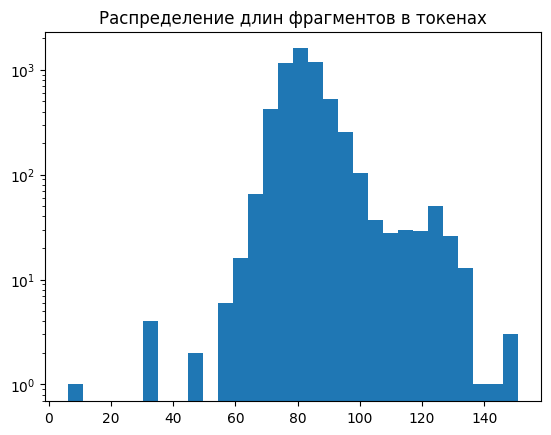

In [26]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

unknown_words = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Неизвестных слов:', unknown_words)

In [27]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(token_ids=train_token_ids, chunk_length=CHUNK_LENGTH, pad_value=0)
test_dataset = LanguageModelDataset(token_ids=test_token_ids, chunk_length=CHUNK_LENGTH, pad_value=0)
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

In [28]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Классы и функции

In [29]:
def mask_for_attention(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)

    return full_mask

mask_for_attention(4)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

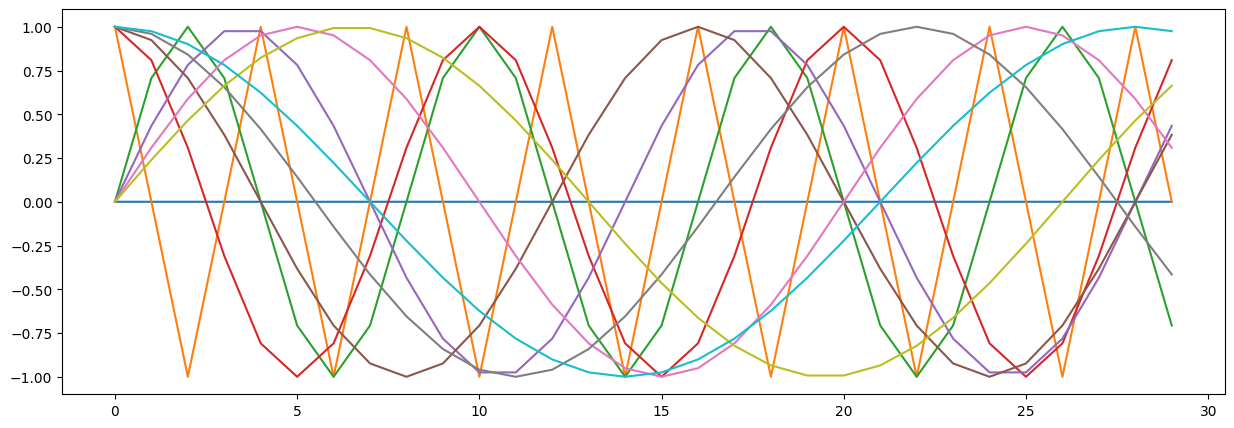

In [30]:
def positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dviders = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dviders[None, :]

    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)

    return result

sample_positional_encoding = positional_encoding(30, 30)
plt.plot(sample_positional_encoding[:, ::3].numpy())
plt.gcf().set_size_inches((15, 5))

## Языковая модель

In [31]:
class LanguageModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size, model, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = torch.nn.Dropout(emb_dropout)
        self.model = model
        self.out = torch.nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        batch_size, max_in_length =  seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        attention_mask = mask_for_attention(max_in_length).to(seed_token_ids.device)

        seed_embs = self.embeddings(seed_token_ids)
        pos_codes = positional_encoding(max_in_length, self.embedding_size).unsqueeze(0).to(seed_embs.device)

        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        target_features = seed_embs
        target_features = self.model(seed_embs, mask=attention_mask, src_key_padding_mask=seed_padding_mask)

        logits = self.out(target_features)
        return logits

## Вспомогательные функции

In [32]:
def lm_cross_entropy(pred, target):
    pred_flat = pred.view(-1, pred.shape[-1])
    target_flat = target.view(-1)

    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

def lr_sheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

In [33]:
class BatchFirstTransformerEncoder(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = torch.nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()

    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()
        result = self.impl(src, *args, **kwargs)
        result = result.transpose(0, 1).contiguous()
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                torch.nn.init.xavier_uniform_(param)
                

In [34]:
torch_model = LanguageModel(vocab_size=tokenizer.vocab_size(), 
                            embedding_size=256, 
                            model=BatchFirstTransformerEncoder(
                                torch.nn.TransformerEncoderLayer(
                                    d_model=256,
                                    nhead=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                num_layers=3),
                            emb_dropout=0.1)

print('Количество параметров:', get_params_number(torch_model))

Количество параметров: 2094312


In [35]:
(best_val_loss, best_torch_model) = train_eval_loop(
    torch_model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=2000,
    batch_size=512,
    device='cpu',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_val=1000
    lr_scheduler_ctor=lr_sheduler
)

Эпоха 0
Досрочно отсановлено пользователем
